# Tutorial file for the r-place-emergence package

#### Imports

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
import json

import rplacem.canvas_part as cp
import rplacem.canvas_part_statistics as cpst
import rplacem.compute_variables as compute
import rplacem.variables_rplace2022 as var
import rplacem.utilities as util
import rplacem.plot_utilities as plot

### Choose an index from the atlas.json file to identify a composition of interest

The r/place [atlas](https://place-atlas.stefanocoding.me/about)
"is an atlas aiming to chart all the artworks created during the r/place April Fools event on Reddit in 2022. It is made with information to each artwork of the canvas provided by the community. The original code was developed by Roland Rytz and is available under the free AGPL license on GitHub. The currently maintained version of the website is managed by Stefano Haagmans and is obtainable under the same license within a [GitHub fork](https://github.com/placeAtlas/atlas). Initial images are provided by Alex Tsernoh."

Each "artwork" or as we call it here, "composition", is indexed according to a string of numbers, found in the atlas.json file. Here, we choose one arbitrarily for demonstration

In [2]:
atlas_id_index = '000297'

### Load all the pixel data from the npz file

Next, we load all the pixel change data from the npz file. This npz file is a condensed, time-sorted version of the 79 data files provided by reddit from the 2022 r/place experiment. The get_all_pixel_changes() function loads this data and places it into an array with 6 columns

In [3]:
pixel_changes_all = util.get_all_pixel_changes()

Print the columns of the pixel_changes_all array for reference

In [4]:
print('  seconds: ' + str(pixel_changes_all['seconds']))
print('  x coord: ' + str(pixel_changes_all['xcoor']))
print('  y coord: ' + str(pixel_changes_all['ycoor']))
print('  user id: ' + str(pixel_changes_all['user']))
print(' color id: ' + str(pixel_changes_all['color']))
print('mod event: ' + str(pixel_changes_all['moderator']))

  seconds: [3.15000000e-01 1.26710000e+01 1.66260000e+01 ... 3.00590172e+05
 3.00590195e+05 3.00590207e+05]
  x coord: [  42  999   44 ...  770 1046    0]
  y coord: [  42  999   42 ...  866 1721 1999]
  user id: [4068945 4068946 4068947 ... 2778754 1591567  583562]
 color id: [16  7 10 ... 31 31 31]
mod event: [False False False ... False False False]


### Define two types of CanvasPart objects

The CanvasPart class is a superclass with subclasses CanvasComposition and CanvasArea. You can think of a CanvasPart as a part of the canvas defined by a spatial border, which can be either defined by the edge of a particular artwork composition as defined by the r/place Atlas or it can be defined by an arbitrary user-defined border path, which can take any shape. The maximum size of a user-defined border is the size of the canvas itself. 

##### Define a CanvasCompsition object

To define a CanvasComposition object, you must supply the atlas composition id index and the pixel change data loaded from the npz file. The constructor then finds and sets the border path, the x and y coordinates inside the border, and the pixel changes within the border of the composition. 

In [5]:
atlas, atlas_size = util.load_atlas()

In [6]:
canvas_comp = cp.CanvasPart(id = atlas_id_index, atlas = atlas, verbose = True)

set border path (with _get_atlas_border() if composition)
set coordinates (with _get_bounded_coords() if is not rectangle)
_reject_off_times()
set pixel changes with _find_pixel_changes_in_boundary()
    find pixels inside boundary
    sort pixel_changes vs coordinates
    determine if the pixel change is in the active timerange
    make pixel_changes output
    find redundant pixel changes
    find changes with cheated cooldown
_set_has_loc_jump()


In [7]:
util.check_time('cp.CanvasPart(id=atlas_id_index, pixel_changes_all=pixel_changes_all, atlas=atlas)')
# getting rid of ind for loop: 0.892 vs 1.632

         456705 function calls (418021 primitive calls) in 2.588 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.588    2.588 {built-in method builtins.exec}
        1    0.000    0.000    2.588    2.588 <string>:1(<module>)
        1    0.000    0.000    2.588    2.588 canvas_part.py:99(__init__)
        1    0.734    0.734    2.316    2.316 canvas_part.py:347(_find_pixel_changes_in_boundary)
        5    1.380    0.276    1.380    0.276 {method 'argsort' of 'numpy.ndarray' objects}
        1    0.053    0.053    0.982    0.982 canvas_part.py:433(_find_cheated_pix_change)
46445/7761    0.125    0.000    0.825    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        7    0.000    0.000    0.488    0.070 fromnumeric.py:51(_wrapfunc)
        1    0.007    0.007    0.466    0.466 canvas_part.py:457(_find_redundant_pix_change)
        2    0.000    0.000    0.45

In [8]:
print(canvas_comp.__str__())

CanvasPart 
Atlas Composition, id: 000297,         
Rectangle, 1 time-dependent border_path(s)
7735 pixels in total, x in [1800, 1890], y in [539, 623]        
419109 pixel changes (including 419109 in composition time ranges)        

Description: 
The titular protagonist of the Kirby video game series, developed by HAL Laboratory and published by Nintendo.

YouTube streamer Ludwig used his chat to overtake the Kirby built by Russian streamer Bratishkinoff. The art was overall loved by all communities (including Bratishkinoff) and saw minimal sabotage throughout the remaining time. 

Pixel changes: 
[( 99663.452,  267, 4850869,  5,  True, False, False, False, False)
 ( 99670.916, 1125, 5678690,  2,  True, False, False, False, False)
 ( 99682.882, 7002, 3066810,  5,  True, False, False, False, False) ...
 (300573.411, 6357, 1743202, 31,  True, False, False,  True, False)
 (300583.048, 7684, 8855771, 31,  True, False, False,  True, False)
 (300584.884, 7569, 9899334, 31,  True, False, F

##### Define a CanvasArea object
To define a CanvasArea object, you must supply the border path and the pixel changes from the npz file. 
The border path is a numpy array of x,y points that form the path of the border of the canvas

In [9]:
border_path = [[[0,0],[0,10],[10,10],[10,0]]]
canvas_area = cp.CanvasPart(border_path=border_path, pixel_changes_all=pixel_changes_all)
canvas_area.description = 'The top left 100 pixels'

In [10]:
print(canvas_area)

CanvasPart 
user-defined area, name: rectangle_0.0_to_10.10,         
Rectangle, 1 time-dependent border_path(s)
121 pixels in total, x in [0, 10], y in [0, 10]        
197538 pixel changes (including 197538 in composition time ranges)        

Description: 
The top left 100 pixels 

Pixel changes: 
[(2.17030000e+01, 24, 4068948, 22,  True, False, False, False, False)
 (1.69534000e+02,  0, 4068955, 27,  True, False, False, False, False)
 (4.90058000e+02, 12, 4068959, 25,  True, False, False, False, False) ...
 (3.00589027e+05,  0, 1256236, 31,  True, False, False,  True, False)
 (3.00589360e+05,  1,  364556, 31,  True, False, False,  True, False)
 (3.00589387e+05,  0, 1295679, 31,  True, False, False,  True, False)]        



## Define a CanvasPartStatistics object

In [11]:
canvas_part_stat = cpst.CanvasPartStatistics(canvas_comp,
                                             n_tbins=40,
                                             tmax=var.TIME_TOTAL,
                                             compute_vars={'stability': 3, 'entropy': 3, 
                                                           'transitions': 3, 'attackdefense': 3},
                                             sliding_window=14400,
                                             returnt_binwidth=100,
                                             trans_param=[0.2, 0.05, 7200, 10800],
                                             timeunit=300,
                                             dont_keep_dir=False)

/Users/annie/Code/Repositories/r-place-emergence/rplacem/compute_variables.py:318: UserWarning: Compression algorithm DEFLATE with BMP to PNG can only handle ravel flattening. Using ravel instead of hilbert_sweetsourcod
  warnings.warn(('Compression algorithm DEFLATE with BMP to PNG can only handle ravel flattening. Using ravel'
/Users/annie/opt/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:715: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000297/VsTimeStab/MostStableColor_time000000t_fps15.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000297/VsTimeStab/MostStableColor_time000000t_fps15.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000297/VsTimeStab/MostStableColor_time000000t_fps15.mp4
Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000297/VsTime/canvaspart_fps15.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000297/VsTime/canvaspart_fps15.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000297/VsTime/canvaspart_fps15.mp4
Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000297/attack_defense_ratio/attack_defense_ratio_perpixel_time000_fps15.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000297/attack_defense_ratio/attack_defense_ratio_perpixel_time000_fps15.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000297/attack_defense_ratio/attack_defense_ratio_perpixel_time000_fps15.mp4
Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000297/AttDefImg/SlidingRef_time000_fps6.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000297/AttDefImg/SlidingRef_time000_fps6.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/000297/AttDefImg/SlidingRef_time000_fps6.mp4


### Get the pixel changes over time, plot, and save a movie of the frames

Now, we can start to examine how the two CanvasPart objects change over time. 

First, let's plot the canvas_comp object for the specified time steps. You'll notice the plotting function returns a list of indices that allow us to quickly select the pixel change data at different time points inside the boundary. The time_inds_list_comp will come in handy for time-step calculations later on. 

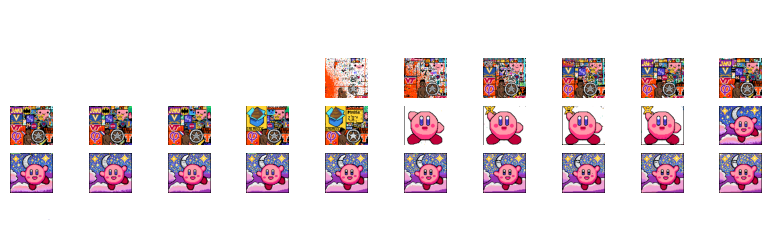

In [12]:
plot.show_canvas_part_over_time(canvas_part_stat.true_image, figsize = (10,3))

We can do the same for the canvas_area object

In [13]:
canvas_area_stat = cpst.CanvasPartStatistics(canvas_area,
                                             n_tbins=20,
                                             tmax=var.TIME_TOTAL,
                                             compute_vars={'stability': 3, 'entropy': 3, 
                                                           'transitions': 3, 'attackdefense': 3},
                                             sliding_window=14400,
                                             returnt_binwidth=100,
                                             trans_param=[0.2, 0.05, 7200, 10800],
                                             timeunit=300,
                                             dont_keep_dir=False)

/Users/annie/Code/Repositories/r-place-emergence/rplacem/canvas_part_statistics.py:378: UserWarning: The interval size is larger than the sliding window. Choose a smaller interval size or a larger sliding window.
  warnings.warn('The interval size is larger than the sliding window. Choose a smaller interval size or a larger sliding window.')
/Users/annie/Code/Repositories/r-place-emergence/rplacem/compute_variables.py:318: UserWarning: Compression algorithm DEFLATE with BMP to PNG can only handle ravel flattening. Using ravel instead of hilbert_sweetsourcod
  warnings.warn(('Compression algorithm DEFLATE with BMP to PNG can only handle ravel flattening. Using ravel'
/Users/annie/opt/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:715: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/Users/annie/Code/Repositories/r-place-emergence/rplacem/canvas_part_statistics.py:415: UserWarning: There are negative return times, this is a problem!
  warnings.warn('

19 [ 5.56660000e+00  8.63860000e+00  1.52480000e+01  1.24800000e+01
  1.55570000e+01  2.24850000e+01  1.31040000e+01  3.36400000e+00
  6.34300000e+00  4.76200000e+00  4.69000000e+00  9.33900000e+00
  3.36346600e+02  3.16907600e+02  6.24283960e+03  1.83684960e+03
  6.63267360e+03  1.08693760e+03  2.67218260e+03  9.93075060e+03
  7.18591460e+03  9.78498260e+03  8.44900000e+00  2.80031600e+02
  2.84558600e+02  2.79166760e+03  8.34144600e+02  3.03967860e+03
  3.03766860e+03  1.19630160e+03  1.22454616e+04  1.38072106e+04
  0.00000000e+00  4.93000000e+00  4.69524600e+02  8.75644600e+02
  9.65059600e+02  1.21122460e+03  7.12417560e+03  7.33688600e+02
  7.56311360e+03  1.14891886e+04  1.29142976e+04  0.00000000e+00
  1.18700000e+01  6.02899360e+03  1.10008600e+02  2.12093760e+03
  5.07788600e+02  3.57743060e+03  9.22647760e+03  7.93457160e+03
  1.30957256e+04  1.31161786e+04  8.93298660e+03  5.90100000e+00
  1.05317556e+04  8.58136000e+01  5.41377600e+02  3.34073260e+03
  5.52254160e+03  7.70

Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/VsTimeStab/MostStableColor_time015029t_fps15.mp4
Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/VsTime/canvaspart_fps15.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/VsTime/canvaspart_fps15.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/VsTime/canvaspart_fps15.mp4


Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/attack_defense_ratio/attack_defense_ratio_perpixel_time000_fps15.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/attack_defense_ratio/attack_defense_ratio_perpixel_time000_fps15.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/attack_defense_ratio/attack_defense_ratio_perpixel_time000_fps15.mp4
Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/AttDefImg/SlidingRef_time015_fps6.mp4.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/AttDefImg/SlidingRef_time015_fps6.mp4



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/rplacem/../figs/rectangle_0.0_to_10.10/AttDefImg/SlidingRef_time015_fps6.mp4


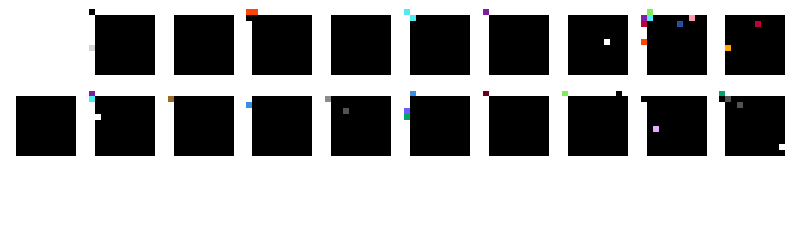

In [14]:
plot.show_canvas_part_over_time(canvas_area_stat.true_image, figsize = (10,3))

##### Save the frames as  movie

In [15]:
image_path = os.path.join(os.getcwd(), 'figs', '000297','VsTime')
image_path_area = os.path.join(os.getcwd(), 'figs', 'rectangle_0.0_to_10.10','VsTime')

In [17]:
util.save_movie(image_path, 
              movie_tool='moviepy',
              fps=6,
              codec='mpeg4',#'libx264',
              video_type='mov')# 'mp4'

util.save_movie(image_path_area, 
              movie_tool='moviepy',
              fps=6,
              codec='mpeg4',#'libx264',
              video_type='mov')# 'mp4'


Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/figs/000297/VsTime/canvaspart_fps6.mov.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/figs/000297/VsTime/canvaspart_fps6.mov



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/figs/000297/VsTime/canvaspart_fps6.mov
Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/figs/rectangle_0.0_to_10.10/VsTime/canvaspart_fps6.mov.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/figs/rectangle_0.0_to_10.10/VsTime/canvaspart_fps6.mov



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/figs/rectangle_0.0_to_10.10/VsTime/canvaspart_fps6.mov


# Plot

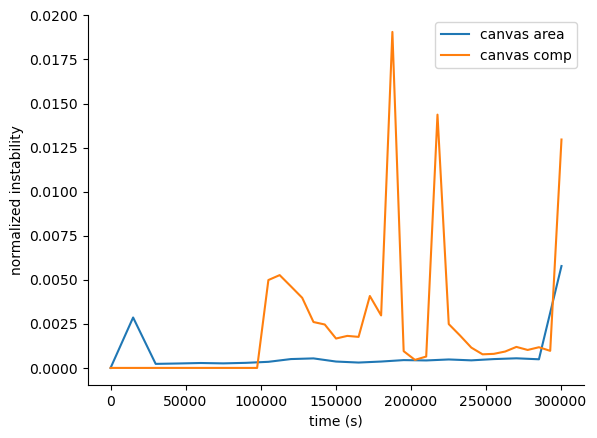

In [20]:
plt.plot(canvas_area_stat.t_ranges, canvas_area_stat.instability_norm.val, label = 'canvas area')
plt.plot(canvas_part_stat.t_ranges, canvas_part_stat.instability_norm.val, label='canvas comp')
sns.despine()
plt.ylabel('normalized instability')
plt.xlabel('time (s)')
sns.despine()
plt.ylabel('normalized instability')
plt.xlabel('time (s)')
plt.legend()

Save

In [15]:
# Open a file and save the object using pickle.dump()
with open('canvas_comp_stat.pickle', 'wb') as f:
    pickle.dump(canvas_part_stat, f)